# GenAI on Vertex SDK Basics

---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [40]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.storage', 'google-cloud-storage'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('google.cloud.secretmanager', 'google-cloud-secret-manager'),
    ('google.genai', 'google-genai'),
    ('websockets', 'websockets')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} --upgrade -q
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} --upgrade -q

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [2]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

inputs:

In [23]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'mg-ce-demos'

In [24]:
REGION = 'us-central1'

# Set the BUCKET name for saving work:
BUCKET = PROJECT_ID
SECRET_ID = "google-aistudio" # for using Google AI Studio
SECRET_VERSION_ID = 1

packages:

In [59]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage
from google.cloud import secretmanager

import vertexai.vision_models # Imagen Models
import vertexai.preview.vision_models
import vertexai.language_models # PaLM and Codey Models
import vertexai.generative_models # for Gemini Models
from vertexai.generative_models import (
GenerationConfig,
GenerativeModel,
Tool,
Part,
Image,
grounding,
)

from google import genai # new unified SDK
from google.genai import types

import json
import io
import base64
import asyncio
import requests
import IPython
import datetime, time
import contextlib
import wave
import itertools
from websockets.asyncio.client import connect
from IPython.display import display, Audio
import pathlib
from PIL import Image
     

In [42]:
print("Vertex AI version: " + str(aiplatform.__version__))

Vertex AI version: 1.74.0


clients:

In [27]:
vertexai.init(project = PROJECT_ID, location = REGION)
gcs = storage.Client(project = PROJECT_ID)
bq = bigquery.Client(project = PROJECT_ID)

bucket = gcs.lookup_bucket(BUCKET)

In [28]:
prompt = "What is a mulligan?"

In [29]:
generation_config = GenerationConfig(temperature=1.0)

---
## Vertex AI SDK

### Model list

In [62]:
# Gemini Models
gemini_text = vertexai.generative_models.GenerativeModel("gemini-1.0-pro-002")
gemini_multimodal = vertexai.generative_models.GenerativeModel("gemini-1.0-pro-vision-001")
gemini15_multimodal = vertexai.generative_models.GenerativeModel("gemini-1.5-pro-002")
gemini15_flash = vertexai.generative_models.GenerativeModel("gemini-1.5-flash-002")
gemini2_flash = vertexai.generative_models.GenerativeModel("gemini-2.0-flash-exp") # new experimental model

# PaLM and Codey Models
text_model = vertexai.language_models.TextGenerationModel.from_pretrained('text-bison')
chat_model = vertexai.language_models.ChatModel.from_pretrained('chat-bison')
textembed_model = vertexai.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko')
codegen_model = vertexai.language_models.CodeGenerationModel.from_pretrained('code-bison')
codecomp_model = vertexai.language_models.CodeGenerationModel.from_pretrained('code-gecko')
codechat_model = vertexai.language_models.CodeChatModel.from_pretrained('codechat-bison')

# Imagen Models
imagecap_model = vertexai.vision_models.ImageCaptioningModel.from_pretrained("imagetext")
imageqna_model = vertexai.vision_models.ImageQnAModel.from_pretrained("imagetext")
imagetext_model = vertexai.vision_models.ImageTextModel.from_pretrained("imagetext")
multimodalembed_model = vertexai.vision_models.MultiModalEmbeddingModel.from_pretrained('multimodalembedding')
imagen1 = vertexai.preview.vision_models.ImageGenerationModel.from_pretrained('imagegeneration@002')
imagen2 = vertexai.preview.vision_models.ImageGenerationModel.from_pretrained('imagegeneration@005')
imagen3 = vertexai.preview.vision_models.ImageGenerationModel.from_pretrained('imagen-3.0-generate-001')

### Text Prompt

In [9]:
response = gemini2_flash.generate_content(prompt)
#response

In [11]:
IPython.display.Markdown(response.text)

The term "mulligan" has a few different meanings, but it most commonly refers to a second chance or redo, typically in a game. Here's a breakdown of the most common uses:

**1. In Golf:**

* **The Classic Mulligan:** In golf, a mulligan is an informal rule (not part of the official rules of golf) that allows a player to replay a shot, typically on their first tee shot. It's essentially a "do-over" for a bad initial attempt.
* **Casual Golf Only:** Mulligans are almost exclusively used in casual or friendly rounds of golf. They are never allowed in tournaments or competitive play.
* **A Gentleman's Agreement:** The use of mulligans is usually a mutual agreement between the players involved.
* **Different Interpretations:** There can be variations in how mulligans are used. Some groups allow only one per round, some allow them only on the first tee, and others have looser rules.

**2. In Other Games (Less Common but Similar Concept):**

* **Card Games (Hand Re-deal):** In some card games, like poker or Magic: The Gathering, a "mulligan" might refer to the option to discard your starting hand and receive a new one, often with some penalty (like drawing fewer cards in the new hand).
* **General "Do-Over":** More broadly, "mulligan" can sometimes be used informally to mean any kind of redo or second chance in other games or situations, even outside of golf.

**3. In General Conversation:**

* **Informal "Second Chance":** In everyday conversations, you might hear someone say they want a "mulligan" when they've made a mistake or want to try something again. It carries the same connotation of wanting a do-over.

**Key Takeaways:**

* **Most common use is in golf:** This is where the term originated and is most commonly recognized.
* **Informal and Casual:** Mulligans are typically used in casual settings and are not part of official rules.
* **A "Do-Over":** The core concept is that it's a second chance to correct a mistake.
* **Context is Important:** The specific rules and usage of a mulligan can vary depending on the context.

In summary, a mulligan is generally a second chance, most notably in golf, where it's a do-over of a bad shot, usually the first tee shot. It implies a more relaxed and casual approach to whatever is being played.


### Streaming Response

In [12]:
for stream_response in gemini2_flash.generate_content(prompt, stream = True):
    print(stream_response.text)

The
 term "mulligan" generally refers to **a second chance to perform an
 action, typically in a game, after a flawed or unsatisfactory first attempt.** It
's most commonly used in golf, but it can also appear in other contexts.

Here's a more detailed breakdown of what a mulligan means:


**In Golf:**

* **Definition:** In golf, a mulligan is an informal rule that allows a player to replay a shot, usually the first
 shot of a round or a tee shot, without incurring a penalty.
* **Informal Nature:** Mulligans are not recognized by the official rules of golf. They are purely a friendly agreement among players.
* **Common Usage:**
 Mulligans are often used in casual, non-competitive rounds of golf, especially among friends. They're meant to be a forgiving way to start the game.
* **Variations:** Some groups might allow a mulligan only on
 the first tee, while others might allow a limited number of mulligans per round, or even on specific holes.
* **Etymology (Origin):** The origin of the 

### Async Response

In [21]:
response = await gemini2_flash.generate_content_async(prompt)
#print(response.text)
IPython.display.Markdown(response.text)

A "mulligan" is a term used primarily in golf (but also sometimes in other casual games) to describe a **do-over** or a **second chance** on a shot. It essentially means you get to replay a shot without it counting against your score.

Here's a breakdown of what a mulligan means and how it's typically used:

**In Golf:**

* **Purpose:** It's typically offered to a player who has hit a particularly bad shot, usually at the beginning of a round or at the beginning of a hole.
* **Informal:** Mulligans are **not part of the official rules of golf**. They are entirely a social, casual, and often self-imposed thing. You won't see mulligans allowed in formal tournaments or competitions.
* **Usage:**
    * **First Tee:** The most common time for a mulligan is on the first tee. Players might offer each other a "mulligan off the first" to loosen up or after a particularly bad start.
    * **Awkward Shots:** Sometimes a player might ask for a mulligan after a truly horrendous shot, especially if it was due to a bad swing or a misstep.
    * **Agreed Upon:** Mulligans are usually offered or agreed upon beforehand within the group of players.
* **Limitations:** There's often an unspoken limit to how many mulligans someone can take, usually just one or two per round, or one per person per the whole round. Using too many is generally considered bad sportsmanship.
* **House Rules:** The use and frequency of mulligans often depend on the "house rules" of the particular group playing golf. Some groups don't allow them at all, while others are more lenient.

**Beyond Golf:**

* **Casual Games:** The term "mulligan" has extended to other casual games and even to everyday situations, meaning simply a second chance to correct a mistake.
* **Figurative Language:** You might hear someone use "mulligan" figuratively, saying something like, "I wish I could take a mulligan on that conversation." This just means they wish they could do it over.

**In summary, a mulligan is a second chance or a do-over, typically used in casual golf games to allow a player to redo a bad shot, but it is not an official part of the game's rules.**


### Response with tools

In [36]:
google_search_tool = Tool.from_google_search_retrieval(grounding.GoogleSearchRetrieval()) # doesnt work with Gemini 2.0 flash

In [33]:
response_w_search = gemini15_flash.generate_content(prompt, generation_config=generation_config, tools=[google_search_tool])

In [35]:
IPython.display.Markdown(response_w_search.text)

A mulligan is a second chance to perform an action, typically after the first attempt was unsuccessful due to a mistake or bad luck.  While its most well-known use is in golf, where it informally allows a player to replay a stroke without penalty (contrary to official rules), the term's broader meaning encompasses any situation where someone is given a "do-over."  In some contexts, it might even refer to a type of stew made from leftover ingredients.


### Image generation

In [60]:
image_prompt = "Generate an image of a futuristic Atlanta anime style"

In [63]:
images = imagen3.generate_images(
    prompt=image_prompt,
    number_of_images=2,
    language="en",
    aspect_ratio="1:1",
#    safety_filter_level="block_none", # allowlist
#    person_generation="allow_adult", # allowlist
)

In [67]:
## save images to files
images[1].save(location="output_images/atlanta_future_anime.jpg", include_generation_parameters=False)

## View the generated image in a notebook.
#for img in images:
#    img.show()

#print(f"Created output image using {len(images[0]._image_bytes)} bytes")

### Incorporate system instruction

In [62]:
system_prompt = "You are a golf expert, deeply familiar with the rules of golf and can explain golf concepts succinctly to anyone"
gemini2_flash_w_system = vertexai.generative_models.GenerativeModel("gemini-2.0-flash-exp", system_instruction=system_prompt) # new experimental model

In [63]:
response = gemini2_flash_w_system.generate_content(prompt)

In [64]:
IPython.display.Markdown(response.text)

A mulligan is a do-over, a second chance to hit a shot, usually off the tee. **It's not part of the official rules of golf, and is generally only used in casual or social rounds.** Think of it like a "friendly" rule exception.


### Document understanding (PDF on GCS)

In [71]:
file_prompt = "can you summarize this file into key points, providing examples explaining each key point? the response should be in markdown format"
pdf_file = Part.from_uri(
    uri="gs://mg-ce-demos/genai-demo-data/2023forresterteivertexai.pdf",
    mime_type="application/pdf",
)
contents = [pdf_file, file_prompt]

In [72]:
response = gemini2_flash.generate_content(contents)

In [73]:
IPython.display.Markdown(response.text)
#print(response.text)

Certainly! Here's a summary of the key points from the document, formatted in Markdown, with examples:

**Executive Summary**

This Forrester report examines the Total Economic Impact (TEI) of Google Cloud Vertex AI. It's based on interviews with 7 representatives from 5 organizations using Vertex AI, and the report consolidates this info into a "composite organization" (a ML-mature company with $20B in revenue).  The report aims to provide a framework for understanding the potential financial impact of Vertex AI investments.

**Key Findings**

*   **Quantified Benefits:** Vertex AI delivers significant financial benefits, quantified as a risk-adjusted Present Value (PV) of **$18.4 million** over three years for the composite organization.

    *   **Example:** The report breaks down how this $18.4 million comes from factors like saved time and new profits.

*   **Improved ML Lifecycle Efficiency:**  A large portion of the financial benefits come from streamlining the machine learning model lifecycle, valued at **$4.5 million**. This includes:

    *   **Example:**  Vertex AI accelerates each step, from data preparation to model monitoring. A key benefit here was saving 64% of time per model created. Integrations with tools like BigQuery, AutoML, and Pipelines, made each step faster. Data scientists now spend less time doing tasks like extracting data from source to use in ML, and spend more time focused on building the actual models.
    *   **Example:**  Faster data collection with Vertex Al. Before Vertex Al, it took a financial services company 20 hours to ingest data. With Vertex Al, this was reduced to 6 hours. Another financial services company's time decreased from weeks to three days in data gathering by leveraging Vertex Al.

*   **Increased Incremental Profit:**  Vertex AI improves model performance, generating an extra **$7.6 million** in profit.

    *   **Example:** Improved model quality leads to better business decisions and new revenue streams.  A financial service company improved fraud detection with Vertex Al's models and saw a 30% increase in revenue by accurately adjusting pricing.

*   **Business User Efficiency:**  Business users are now empowered to incorporate AI into workflows, resulting in **$1.2 million** in savings.

    *   **Example:**  Business users can now automate tasks previously done manually, saving 2 hours a week per user. A financial services company created a chatbot to answer client questions, which both accelerated the process and freed up human workers to focus on more complicated tasks.

*   **Legacy System Savings:** Organizations can decommission old, costly on-premises and third-party solutions, saving **$5.1 million**.

     *   **Example:**  Organizations no longer have to pay license fees for multiple different ML-related products, leading to cost savings. One retail company that reduced vendor costs by $500,000 per year by moving to Vertex AI.

*   **Unquantified Benefits:** Vertex AI also offers non-quantified benefits like:
  * **Scaling ML with current headcount**: Vertex Al helped companies grow their ML capacity without needing to hire additional resources.
  *  **Improved talent acquisition and retention**: Access to Vertex Al was a selling point in recruiting and retaining data science employees.
  *  **Improved security, compliance, and governance:** Vertex Al offered improved transparency and security through built-in controls, which helped with regulatory needs.

**Key Challenges Prior to Vertex Al**

*   **Siloed Tools:** Disparate, unintegrated point solutions created significant roadblocks to efficiency, collaboration, and innovation. Teams used different tools for different parts of the ML lifecycle.
    *   **Example:** Different business units had their own set of servers for ML, with different teams at different levels of maturity and efficiency.
*   **Labor-Intensive Data Preparation:** Preparing data for ML was a manual, time-consuming, and cumbersome process.
    *   **Example:** Data teams spent significant time sourcing, extracting, cleaning, and combining data. This slowed down the ML lifecycle.
*   **Inefficiencies in Model Development:** Creating, deploying, and maintaining models was slow, difficult, and lacked key capabilities.
    *   **Example:**  Organizations struggled to provide explanations for their models and found it difficult to monitor the performance of models after deployment.
*   **Inability to Keep Up:** Business demands and project backlogs were hindered by legacy ML solutions.
    *   **Example:** It could take 6 months to get certain models into production, which could have a huge negative impact on business outcomes.
*   **Lack of Collaboration and Innovation:** Data science, engineering, and business teams were siloed, preventing effective collaboration and innovation.
  * **Example:**  Data scientists would build a model and hope that it worked, but there was no way to correct errors if there was no team to collaborate with.

**Investment Objectives**

Organizations sought a solution that would:

*   Standardize ML workflows and enable reusability.
*   Improve time to market and model accuracy.
*   Improve visibility, collaboration, and democratize ML.
*   Enable focus on innovation, not on ML infrastructure.
*   Provide flexibility and allow the selection of specific features based on need.

**Costs**

The report identified the following costs (3 year PV):

*   **Platform Usage Fees:** **$3 million**.  These costs are lower than the costs associated with an on-premise environment of a similar size.
*   **Implementation and Ongoing Management:** **$406,000**. These include fees for professional services and the time spent internally by staff on implementation and maintenance.
*   **Training Fees:** **$281,000**. This includes training fees for data scientists, engineers, and business users.

**Overall Impact**

*   Vertex Al delivers a **Net Present Value (NPV) of $14.74 million** and a **Return on Investment (ROI) of 397%** over three years. This is a large ROI driven by all of the benefits listed above.

**Key Quotes**

The report is filled with key quotes that highlight the impact of Vertex AI on various aspects of the composite organization's business. For example:

*   *"We had two main goals. Firstly, we wanted to give data scientists the tools they need to understand data faster while making sure we don't overspend on the resources they consume when they build models. And secondly, ensure they could take those models and put them into production and into experiments as quickly as possible while ensuring quality. Time to value at low cost is extremely important to us, and Vertex Al has helped us improve that immensely."*
* *"Vertex Al's dashboarding, visualization, logging, monitoring, and metrics are all tied together seamlessly. It makes the platform easy to use for anyone."*

**In Summary**

The report concludes that Vertex AI offers a compelling solution for organizations looking to democratize AI, improve ML efficiencies, and drive tangible business outcomes. By addressing the common challenges associated with legacy ML environments, it empowers data teams to accelerate model development, deployment, and innovation. The report also shows that the cost of using Vertex Al is lower than the cost of maintaining an on-premise environment, while offering a more seamless integration and collaboration experience.

Let me know if you'd like any specific points elaborated on!


### Image understanding (local)

In [79]:
img_prompt = "can you desribe what is in this image?"
image_part = Part.from_image(Image.load_from_file("/Users/mikegoodman/Documents/dev/data/images/darrow_anime.png"))
contents = [image_part, img_prompt]

In [80]:
response = gemini2_flash.generate_content(contents)

In [81]:
IPython.display.Markdown(response.text)

Certainly! Here's a description of the image:

**Overall Scene:**

The image depicts a stylized, possibly fantasy or sci-fi, male character standing prominently against a backdrop of a rugged, canyon-like environment. The lighting suggests either sunrise or sunset, with warm orange hues dominating the scene.

**Character:**

*   **Appearance:** The man has pale, almost white, short hair and a stern expression, marked by a scar or lines across his face. He appears to be in his late 20s to early 30s. His musculature is clearly defined, suggesting he is physically fit.
*   **Attire:** He wears a dark, possibly armored, bodysuit with red straps or accents across his torso and limbs. The suit has a segmented design, and he has a prominent, belt-like device with a circular element at his waist. He is also adorned with segmented silver armor on his shoulders and a large, red cape that drapes over his shoulders and back.
*   **Weapon:** He carries a large, curved blade that resembles a scythe, positioned behind his back, with the blade extending upward.
*   **Pose:** The character stands in a forward-facing, almost frontal stance, giving the impression of alertness and preparedness.

**Environment:**

*   **Background:** The background is a rugged terrain, resembling a canyon or rock formation. The warm, orange lighting bathes the scene in a reddish-orange glow.
*   **Depth:** The use of shadows and gradients suggests depth, creating a sense of a natural, rocky environment.

**Style:**

*   **Artistic Style:** The artwork appears to be a digital illustration, possibly in a comic book or graphic novel style, with a strong emphasis on line work and dynamic posing.
*   **Color Palette:** The color palette is dominated by warm tones (reds, oranges) with contrasting dark tones in the character's suit and silver elements in the armor and weapon.

**Overall Impression:**

The image exudes a sense of tension and readiness. The character's stern expression, combined with his unique weapon and attire, suggests he's a warrior or a figure of power. The warm, dramatic lighting and the rocky backdrop contribute to a narrative feeling, as if this figure is standing at a pivotal point in a story.

If you have any other questions about the image, just ask!

---
## Google GenAI SDK

### Setup

In [43]:
# Create the Secret Manager client.
secret_client = secretmanager.SecretManagerServiceClient()
name = f"projects/{PROJECT_ID}/secrets/{SECRET_ID}/versions/{SECRET_VERSION_ID}"
response = secret_client.access_secret_version(request={"name": name})
aistudio_key = response.payload.data.decode("UTF-8")

In [44]:
# Only run this block for Vertex AI API
#google_genai_client = genai.Client(vertexai=True, project=PROJECT_ID, location=REGION) # vertex ai, doesn't seem to work locally?
google_genai_client = genai.Client(api_key=aistudio_key) # google ai studio

#google_genai_client

In [45]:
gemini2_flash_name = 'gemini-2.0-flash-exp'

In [46]:
contents = [
    types.Content(
        role="user",
        parts=[types.Part.from_text(prompt)]
    )
]

In [47]:
generate_content_config = types.GenerateContentConfig(
    temperature = 1,
    top_p = 0.95,
    max_output_tokens = 8192,
    response_modalities = ["TEXT"],
    safety_settings = [types.SafetySetting(
        category="HARM_CATEGORY_HATE_SPEECH",
        threshold="OFF"
    ),types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="OFF"
    ),types.SafetySetting(
        category="HARM_CATEGORY_SEXUALLY_EXPLICIT",
        threshold="OFF"
    ),types.SafetySetting(
        category="HARM_CATEGORY_HARASSMENT",
        threshold="OFF"
    )]
)

  

### Count tokens before submitting

In [56]:
token_count = google_genai_client.models.count_tokens(
    model=gemini2_flash_name,
    contents=prompt,
)

In [58]:
print(prompt)
print(token_count)

What is a mulligan?
total_tokens=7 cached_content_token_count=None


### Streaming response

In [35]:
for chunk in google_genai_client.models.generate_content_stream(
    model = gemini2_flash_name, 
    contents = contents, 
    config = generate_content_config,):
    print(chunk.text, end="")

The term "mulligan" generally refers to **a second chance or an opportunity to redo something, typically after a mistake or poor outcome.** It's most commonly used in the context of golf, but it has expanded to other areas as well.

 it's used:eakdown of what a mulligan means and how

**In Golf:**

 that allows a player to replay a shot, usually the tee shot, without penalty. This is typically done when the initial shot was particularly bad or a beginner made a mistake.
 agreement among players. You might say, "Can I take a mulligan?" after a bad first shot off the tee.
 official golf tournaments or sanctioned play**. They are strictly a casual, recreational practice.
* **Etiquette:** Whether or not to offer or accept a mulligan depends on the group and their agreed-upon rules. Some groups may allow them on the first tee only, while others might not allow them at all.

**Beyond Golf:**

* **General Meaning:** The concept of a mulligan has broadened to mean any kind of second attempt, r

### Complete response

In [36]:
response = google_genai_client.models.generate_content(
    model=gemini2_flash_name, contents=prompt
)

In [37]:
IPython.display.Markdown(response.text)

The term "mulligan" has its roots in golf, but it's used more broadly now. Here's a breakdown of what it means:

**In Golf:**

* **Definition:** A mulligan is an informal rule that allows a player to replay a shot, typically after making a poor one, without incurring a penalty. It's essentially a "do-over."
* **When It's Used:** Mulligans are most commonly used in casual, friendly rounds of golf, not in official tournaments or competitive play.
* **Why It's Used:** It's used to keep the game fun and less frustrating, especially for beginners or those having a bad day.
* **Rules & Variations:** There are no strict rules about mulligans. They're usually agreed upon beforehand by the group. Common variations include:
    * **One Mulligan per round:** Players get one chance to redo a bad shot.
    * **One Mulligan per side:** Players get one per front nine and one per back nine.
    * **Mulligan off the tee:** Usually restricted to the tee shot.
    * **No Mulligan on the green:** Typically, you don't get mulligans on the putting green.
    * **Unlimited Mulligan:** Sometimes in very casual games, the number of mulligans are open.

**Beyond Golf (Figurative Meaning):**

* **Definition:** In a broader, figurative sense, a mulligan means a second chance, a do-over, or an opportunity to correct a mistake.
* **When It's Used:** You might hear it used in:
    * **Work situations:** "I really messed up that presentation, I wish I had a mulligan."
    * **Personal situations:** "I regret what I said, I wish I could have a mulligan on that conversation."
    * **Games (outside of golf):** Though less common, you might hear people jokingly use it in other games for a second attempt at a move.
* **Why It's Used:** It conveys the idea of rectifying a mistake or avoiding a negative consequence by getting another shot at it.

**Key Takeaways:**

* **Context is Key:** The meaning of "mulligan" depends heavily on context. In golf, it's a specific (but informal) rule. Outside of golf, it's a more general term for a second chance.
* **Informal:** In either case, it usually implies an informal or non-strict situation where mistakes are allowed or can be rectified.
* **Common Usage:** While originally from golf, the figurative meaning of "mulligan" has become widely understood and used.

So, whether it's a bad slice on the first tee or a regrettable comment in a conversation, a mulligan represents that coveted chance to "try again."


### Multimodal prompts

In [71]:
image_path = pathlib.Path("output_images/atlanta_future_anime.jpg")
image_bytes = image_path.read_bytes()

In [79]:
image = Image.open(img_path)

In [80]:
response = google_genai_client.models.generate_content(
    model=gemini2_flash_name,
    contents=[
        image,
        "Write a short and engaging blog post based on this picture."
    ]
)

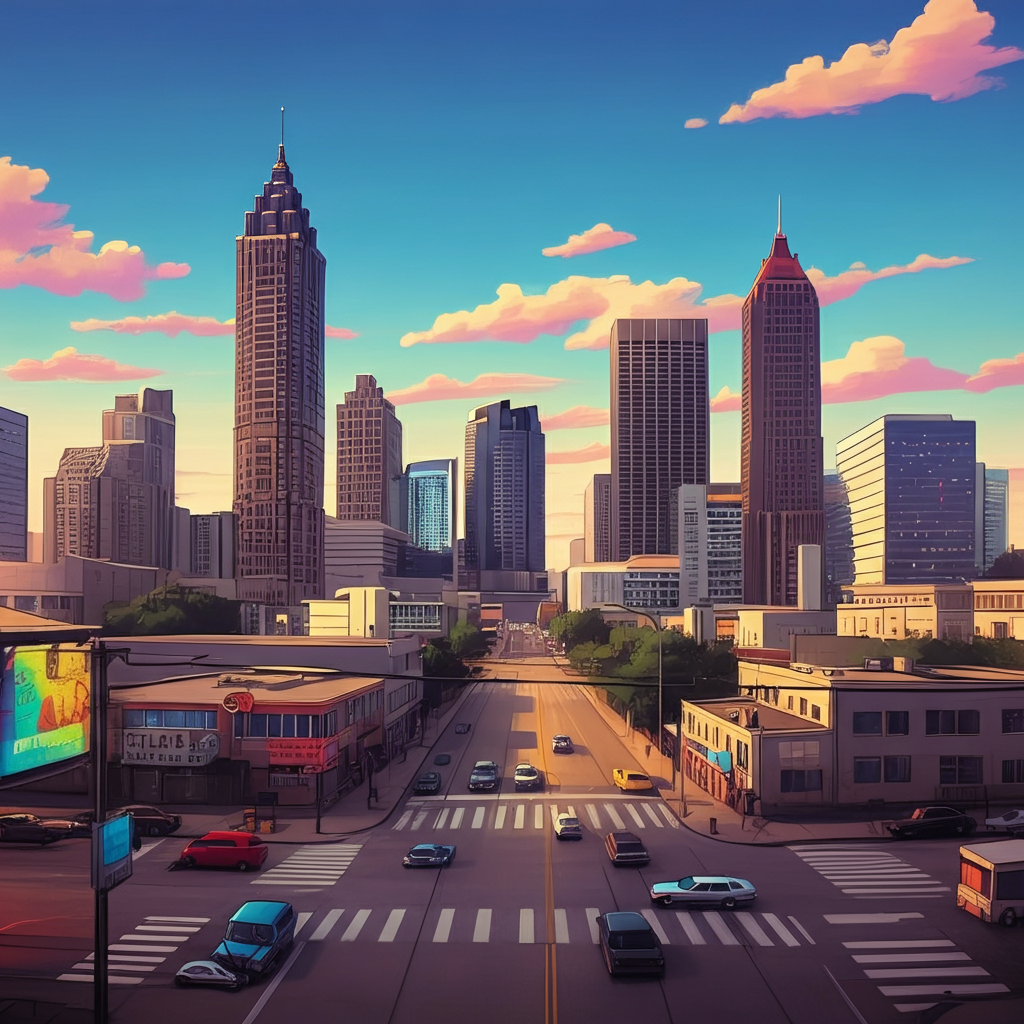

Okay, here's a blog post inspired by the image, aiming for a short and engaging style:

**City Dreams: Where the Sky Turns Pink**

Ever felt that jolt of energy when a city feels just...right? That's what I get from this stunning scene. It's a blend of soaring skyscrapers and everyday street life, all bathed in the soft glow of a sunset sky that's straight out of a dream.

Look at those cotton-candy clouds! They're the perfect counterpoint to the rigid lines of the buildings, adding a touch of magic to the urban landscape. Down below, cars crisscross at the intersection, a familiar rhythm of the city. It's not just about the towering structures; it's about the energy humming in the streets, the little details that make up a place. 

This image captures the duality of city life - the grand and the gritty, the majestic and the mundane. It's a place where big dreams are forged, but also where life happens in the everyday. It’s a reminder that beauty can be found even amidst the hustle and bustle. What cities make you feel this way? Tell me in the comments!

In [82]:
display(image)
IPython.display.Markdown(response.text)